In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from numpy.random import default_rng
rng = default_rng(4993)

We'll create a set of chi-squared distributed data (like the sum of squares of two Gaussians) which are our background. Some fraction of these will then be corrupted with random glitches. We'll assume that we don't know the fraction of glitchy samples, nor do we know much about the glitches.

In [3]:
data_len = 1024
zed_data = rng.chisquare(2, size=data_len)
outliers = rng.binomial(1, 0.03, size=data_len)
glitches = rng.chisquare(45, size=data_len)/3.
zed_data += outliers * glitches

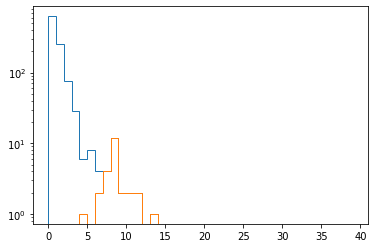

In [4]:
plt.hist(zed_data/2., bins=np.arange(0,40), log=True, histtype='step');
plt.hist(zed_data[outliers > 0.5]/2., bins=np.arange(0,40), log=True, histtype='step');

Here's a simple exponential model. When $\lambda = 1$, this is equivalent to $\chi^2(2)$. But the presence of the glitches will bias the value. 

In [5]:
with pm.Model() as simple_exponential:
    zed = pm.Data('zed', zed_data)                  
    
    lam = pm.Lognormal('lambda', mu=0., sigma=0.25)

    obs = pm.Exponential('obs', lam = lam, observed=zed/2.)

In [6]:
with simple_exponential:
    trc_simple = pm.sample(tune=3000, draws=3000, target_accept=0.9)

/tmp/ipykernel_22865/114607124.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trc_simple = pm.sample(tune=3000, draws=3000, target_accept=0.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 4 seconds.


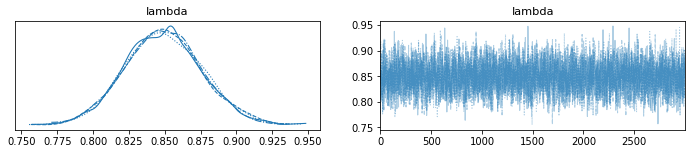

In [7]:
with simple_exponential:
    az.plot_trace(trc_simple)

Now we follow [Dan Foreman-Mackey's blog](https://gist.github.com/dfm/5250dd2f17daf60cbe582ceeeb2fd12f) to model the outliers. The model itself is marginalized over the identity of each point (whether it's an outlier or not), so it just becomes a mixture model of an exponential and our glitch model. Here we'll use a log-normal glitch model, because the power is positive but not much else is known. We put a flat prior on the fraction of glitches.

In [8]:
with pm.Model() as exp_lognorm:
    
    zed = pm.Data('zed', zed_data)                  
    
    mu = pm.Lognormal('mu', mu=0., sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Inlier/outlier likelihoods
    inlier_logl = pm.Exponential.dist(lam = 1.).logp(zed/2.)
    outlier_logl = pm.Lognormal.dist(mu=mu, sigma=sigma).logp(zed/2.)
    
    # This fraction is really the *prior* probability of having an outlier
    frac_outliers = pm.Uniform('frac_outliers', lower=0.0, upper=0.5)
    
    # Apply this prior to compute the joint prob
    inlier_logp = pm.math.log(1 - frac_outliers) + inlier_logl
    outlier_logp = pm.math.log(frac_outliers) + outlier_logl
    
    # Marginalize
    logp_marg = pm.math.logaddexp(
        inlier_logp,
        outlier_logp
    )
    pm.Potential('obs', logp_marg)
    
    # Track the probability that each point is an outlier
    pm.Deterministic("logp_outlier", outlier_logp - logp_marg)

In [9]:
with exp_lognorm:
    trc = pm.sample(tune=6000, draws=3000, target_accept=0.9)

/tmp/ipykernel_22865/1629603765.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trc = pm.sample(tune=6000, draws=3000, target_accept=0.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac_outliers, sigma, mu]


Sampling 4 chains for 6_000 tune and 3_000 draw iterations (24_000 + 12_000 draws total) took 16 seconds.


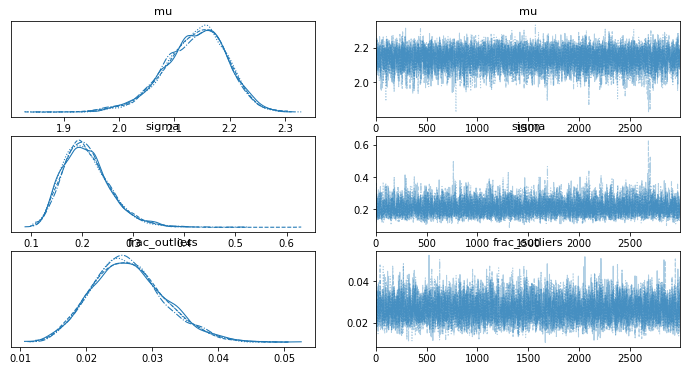

In [10]:
with exp_lognorm:
    rvs = ['mu', 'sigma', 'frac_outliers']
    _ = az.plot_trace(trc, var_names=rvs, combined=False)

DFM's blog has a nice trick to also recover the probability that each point is either background or a glitch. Below, we plot histograms of the inferred glitch probability for each point. We also plot the glitch probability with colour indicating the correct assignment.

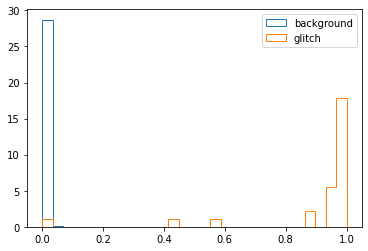

In [14]:
p_outlier = np.exp(np.median(trc["logp_outlier"], axis=0))
plt.hist(p_outlier[outliers < 0.5], bins=np.linspace(0,1,30), density=True, histtype='step', label='background');
plt.hist(p_outlier[outliers > 0.5], bins=np.linspace(0,1,30), density=True, histtype='step', label='glitch');
plt.legend(loc='upper right');

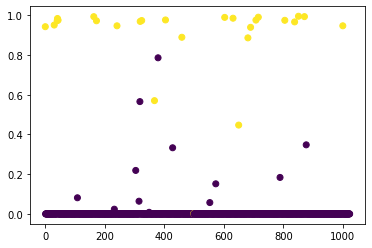

In [12]:
plt.scatter(np.arange(data_len), p_outlier, c=outliers)
plt.ylabel('Glitch probability')

Below is a simpler model with two exponentials, one which has an adjustable slope. It doesn't work as well as the chi-squared with log-normal outliers.

In [13]:
with pm.Model() as two_exp:
    
    zed = pm.Data('zed', zed_data)                  
    
    lam = pm.Lognormal('lam', mu=0., sigma=0.25)            
    
    # Inlier/outlier likelihoods
    inlier_logl = pm.Exponential.dist(lam = 1.).logp(zed/2.)
    outlier_logl = pm.Exponential.dist(lam = lam).logp(zed/2.)
    
    # This fraction is really the *prior* probability of having an outlier
    frac_outliers = pm.Uniform('frac_outliers', lower=0.0, upper=0.5)
    
    # Apply this prior to compute the joint prob
    inlier_logp = pm.math.log(1 - frac_outliers) + inlier_logl
    outlier_logp = pm.math.log(frac_outliers) + outlier_logl
    
    # Marginalize
    logp_marg = pm.math.logaddexp(
        inlier_logp,
        outlier_logp
    )
    pm.Potential('obs', logp_marg)
    
    # Track the probability that each point is an outlier
    pm.Deterministic("logp_outlier", outlier_logp - logp_marg)